<a href="https://colab.research.google.com/github/wanyane/Customer-Confusion-Detection-Using-VTNET/blob/main/WhenToInterrupt_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from PIL import Image

# drive.mount('/content/gdrive')
print('tf: %s, keras: %s, np: %s'%(tf.__version__, keras.__version__, np.__version__))

Mounted at /content/gdrive
tf: 2.3.0, keras: 2.4.0, np: 1.18.5


In [9]:
import numpy as np
import tensorflow as tf

TIME_STEPS = 21
TRANING_DATA_SIZE = 36000
FEATURE_DIM = 6 # tr0, tr1, tr2, ori0, ori1, ori2

# DATA_DIR = './gdrive/Shareddrives/WHEN_TO_INTERRUPT/Winston/data/'
x = np.load(DATA_DIR + 'x.npy', allow_pickle=True)
y = np.load(DATA_DIR + 'y.npy', allow_pickle=True)

x_data = []
y_data = []

# remove the data while labeled by 0 (no testing subject)
for video_idx, data in enumerate(y):
  delete_idx = []
  
  for i in range(len(data)):
    if data[i] == 0:
      delete_idx.append(i)
    else:
      y[video_idx][i] -= 1 # 1->0, 2->1, 3->2
  
  y[video_idx] = np.delete(y[video_idx], delete_idx, 0)
  x[video_idx] = np.delete(x[video_idx], delete_idx, 0)




for seq_idx, data in enumerate(x):
  # print(data.shape)
  for i in range(TIME_STEPS-1, data.shape[0], 1):
    x_data.append(data[i - TIME_STEPS + 1: i+1])
    y_data.append(y[seq_idx][i])

x_data = np.array(x_data)
y_data = np.array(y_data)
# use one hot representation

notconfused, uncertain, confused = 0,0,0
for _, label in enumerate(y_data):
  if label == 0:
    notconfused += 1
  elif label == 1:
    uncertain += 1
  elif label == 2:
    confused += 1
  else:
    print('[WARNING] Unexpexted label')

y_data = tf.one_hot(y_data, depth=3)


# shuffle data
tf.random.set_seed(5)
x_data = tf.random.shuffle(x_data)
tf.random.set_seed(5)
y_data = tf.random.shuffle(y_data)

# split to training and testing data
x_training, x_testing = tf.split(x_data, [TRANING_DATA_SIZE, x_data.shape[0] - TRANING_DATA_SIZE], axis=0)
y_training, y_testing = tf.split(y_data, [TRANING_DATA_SIZE, y_data.shape[0] - TRANING_DATA_SIZE], axis=0)

# normalize (standardlize the training data(x_train and then transform x_testing using the parameters))
x_training = tf.reshape(x_training, (-1, FEATURE_DIM))
x_testing = tf.reshape(x_testing, (-1, FEATURE_DIM))

scaler = StandardScaler() # standard deviation = variance = 1
x_training = scaler.fit_transform(x_training)
x_testing = scaler.transform(x_testing)

x_training = tf.reshape(x_training, (-1, TIME_STEPS, FEATURE_DIM))
x_testing = tf.reshape(x_testing, (-1, TIME_STEPS, FEATURE_DIM))
print(x_training.shape, x_testing.shape)


12311 17732 13246 0
(36000, 21, 6) (7289, 21, 6)


In [4]:
GEN_CNN_IMAGE = False
IMAGE_SIZE = 64 # For now, the input image will always be a square image
x_image_training = np.array(x_training)
x_image_testing = np.array(x_testing)

x_image_training = x_image_training.reshape(-1, FEATURE_DIM)
x_image_testing = x_image_testing.reshape(-1, FEATURE_DIM)

scaler = MinMaxScaler(feature_range=(0,255))
scaler.fit(x_image_training)

x_image_training = scaler.transform(x_image_training)
x_image_testing = scaler.transform(x_image_testing)
x_image_testing = np.clip(x_image_testing, 0, 255)

x_image_training = x_image_training.reshape(-1, TIME_STEPS, FEATURE_DIM)
x_image_testing= x_image_testing.reshape(-1, TIME_STEPS, FEATURE_DIM)



def makeCnnImage(trans_x, orient_x):
  # Make CNN input image
  scan_path_images = []
  for seq_idx in range(trans_x.shape[0]):
    if seq_idx % 10000 == 0:
      print(seq_idx)
   
    trans = trans_x[seq_idx]
    orient = orient_x[seq_idx]

    # Draw path
    scan_path = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    for i in range(trans.shape[0] - 1):
      
      orient0, orient1 = orient[i, :], orient[i+1, :]
      x0, y0 = int(trans[i, 0]) // 4, int(trans[i, 1]) // 4
      x1, y1 = int(trans[i+1, 0]) //4 , int(trans[i+1, 1]) // 4
      dist = np.linalg.norm([x1-x0, y1-y0])
      
      if dist == 0:
        scan_path[int(x0), int(y0)] = np.around((orient0 + orient1)/2)
      else:
        dir_x = (x1-x0) / dist
        dir_y = (y1-y0) / dist
        for j in range(int(np.around(dist))):
            idx_x = x0 + (dir_x * j)
            idx_y = y0 + (dir_y * j)

            inter_orient_data = (orient0 * np.linalg.norm([x1 - idx_x, y1 - idx_y]) + \
                                orient1 * np.linalg.norm([idx_x - x0, idx_y - y0])) / dist
            
            scan_path[int(np.around(idx_x)), int(np.around(idx_y))] = [inter_orient_data[0], inter_orient_data[1], inter_orient_data[2]]      
        
    scan_path_images.append(scan_path)
      
  scan_path_images = np.asarray(scan_path_images)
  return scan_path_images

scan_path_image_training = makeCnnImage(x_image_training[:, :, :2], x_image_training[:, :, 3:])
scan_path_image_testing = makeCnnImage(x_image_testing[:, :, :2], x_image_testing[:, :, 3:])

print(scan_path_image_training.shape, scan_path_image_testing.shape)
  


0
10000
20000
30000
0
(36000, 64, 64, 3) (8423, 64, 64, 3)


In [5]:
# Model Parameters
DATA_DIM = 6 # tr0, tr1, tr2, ori0, ori1, ori2
OUTPUT_DIM = 3 #4 kinds of labeling

HIDDEN1_UNIT = 128
HIDDEN2_UNIT = 64
RNN_FC_UNIT = 32
CNN_CONV1_UINT = 32
CNN_CONV2_UINT = 16
CNN_FC_UNIT = 32
CONCATE_FC_1 = 16
EPOCH = 50


In [6]:

# simple LSTM model


RnnInput = keras.Input(shape=(TIME_STEPS, FEATURE_DIM), name='RnnInput')
lstm1 = keras.layers.LSTM(HIDDEN1_UNIT, return_sequences=True, input_shape=(TIME_STEPS, DATA_DIM))(RnnInput)
lstm2 = keras.layers.LSTM(HIDDEN2_UNIT, return_sequences=False)(lstm1)
RnnOut = keras.layers.Dense(RNN_FC_UNIT, activation='relu')(lstm2)

CnnInput = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='CnnInput')
conv1 = keras.layers.Conv2D(CNN_CONV1_UINT, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))(CnnInput)
maxpooling1 = keras.layers.MaxPooling2D((2,2))(conv1)
conv2 = keras.layers.Conv2D(CNN_CONV2_UINT, (3,3), activation='relu')(maxpooling1)
maxpooling2 = keras.layers.MaxPooling2D((2,2))(conv2)
flat = keras.layers.Flatten()(maxpooling2)
CnnOut = keras.layers.Dense(CNN_FC_UNIT, activation='relu')(flat)

concate = keras.layers.concatenate([RnnOut, CnnOut], axis=1)
concate1 = keras.layers.Dense(CONCATE_FC_1, activation='relu')(concate)


output = keras.layers.Dense(OUTPUT_DIM, activation='softmax')(concate1)
model = keras.Model([RnnInput, CnnInput], output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit({'RnnInput': x_training, 'CnnInput': scan_path_image_training}, y_training, \
                    epochs=EPOCH, batch_size=128, validation_split=0.1)



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CnnInput (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 32)   896         CnnInput[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
RnnInput (InputLayer)           [(None, 12, 6)]      0                                            
_______________________________________________________________________________________

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


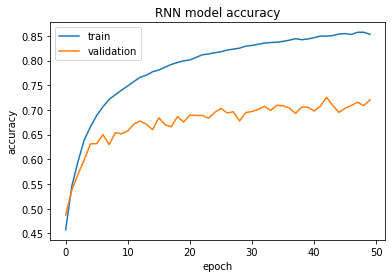

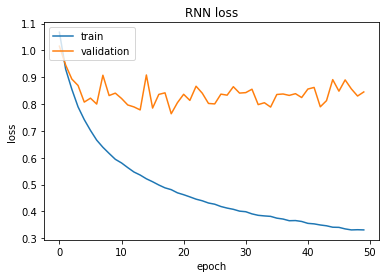

Evaluate on test data
66/66 [==============================] - 8s 116ms/step - loss: 0.8529 - acc: 0.7281
test loss, test acc: [0.8529351353645325, 0.7281253933906555]


In [7]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print("Evaluate on test data")
# results = model.evaluate({'RnnInput': x_testing}, y_testing, batch_size=128)
results = model.evaluate({'RnnInput': x_testing, 'CnnInput': scan_path_image_testing}, y_testing, batch_size=128)

print("test loss, test acc:", results)